# Part 1: Parsing/Reading the data

Before I do anything, I must first make sense of the given data and it's structure.
i.e. parse all the data from txt files.


Destruction of the data (relevant fields):
- movies
    - genres
    - conversations
        - dialogs
            - sentences
                - words

The assignment says **not** to use any data other than "movie_lines.txt",
I'm parsing the entire data set to understand the schema and play around with it later.
For the purpose of Q1, I will only use data that was parsed from "movie_lines.txt".

I'm using the term "dialog" instead of "line" because line is ambiguous, dialog is not.

In [182]:
from torch.utils.data import Dataset
!rm cornell_movie_dialogs_corpus*
!wget http://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip
!unzip -n cornell_movie_dialogs_corpus.zip
!mkdir data
!mv "cornell movie-dialogs corpus" data/
!ls data/"cornell movie-dialogs corpus"

zsh:1: no matches found: cornell_movie_dialogs_corpus*
--2021-08-28 18:03:20--  http://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip
Resolving www.cs.cornell.edu (www.cs.cornell.edu)... 132.236.207.36
Connecting to www.cs.cornell.edu (www.cs.cornell.edu)|132.236.207.36|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9916637 (9.5M) [application/zip]
Saving to: ‘cornell_movie_dialogs_corpus.zip’

cornell_movie_dialo 100%[===================>]   9.46M  6.51MB/s    in 1.5s    

2021-08-28 18:03:21 (6.51 MB/s) - ‘cornell_movie_dialogs_corpus.zip’ saved [9916637/9916637]

Archive:  cornell_movie_dialogs_corpus.zip
   creating: cornell movie-dialogs corpus/
  inflating: cornell movie-dialogs corpus/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/cornell movie-dialogs corpus/
  inflating: __MACOSX/cornell movie-dialogs corpus/._.DS_Store  
  inflating: cornell movie-dialogs corpus/chameleons.pdf  
  inflating: __MACOSX/cornell movie-dialog

In [ ]:
!pip install transformers pydantic pyvis

In [1]:
import re
from collections import Counter, OrderedDict
from contextlib import contextmanager
from copy import deepcopy
from os import listdir, makedirs, getcwd
from os.path import join
from typing import List, Tuple, Dict, Optional, TextIO, Any, Union
from transformers import DistilBertTokenizer, DistilBertModel
import torch
from torch.nn import functional as F
import numpy as np
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import pandas as pd
import spacy
from pydantic import BaseModel
from tqdm import tqdm
import heapq
from pyvis.network import Network
import networkx as nx
from IPython.core.display import display, HTML

In [2]:
BASE_DIR = getcwd()
BASE_DIR

'/Users/akhil/code/lexical_lab/companies/ginger'

I see that the data is fragmented into several files like a relational database.

Something I like to do when we have such relational data models is to create classes for those models.
Pydantic provides an easy, readable and writable framework for this.

In [3]:
class Character(BaseModel):
    name: str
    id: str
    gender: Optional[str]  # m|f|None
    credit_position: Optional[int]

    def __eq__(self, other):
        return self.id == other.id


class Dialog(BaseModel):
    id: str
    speaker: Character
    listener: Optional[Character]
    dialog: str


class Conversation(BaseModel):
    characters: Tuple[Character, Character]
    dialogs: List[Dialog]


class Movie(BaseModel):
    id: str
    title: str
    release_year: int
    imdb_rating: float
    num_votes: int
    genres: List[str] = []
    characters: Dict[str, Character] = {}
    conversations: List[Conversation] = []

In [4]:
def update_movie_characters(movies: Dict[str, Movie], characters_path: str):
    with open(characters_path, "r", encoding="ISO-8859-1") as characters_file:
        for character in characters_file:
            # sample: u0 +++$+++ BIANCA +++$+++ m0 +++$+++ 10 things i hate about you +++$+++ f +++$+++ 4
            character = character.strip().split(" +++$+++ ")
            character_id, name, movie_id, movie_title, gender, position = character

            gender = None if gender == "?" else gender
            position = None if position == "?" else position

            assert movie_id in movies
            movie = movies[movie_id]

            character = Character(
                name=name,
                id=character_id,
                gender=gender,  # m|f|None
                credit_position=position,
            )

            movie.characters[character_id] = character

In [5]:
def get_all_dialogs(movies: Dict[str, Movie], lines_path: str) -> Dict[str, Dialog]:
    all_dialogs = {}
    with open(lines_path, "r", encoding="ISO-8859-1") as dialogs_file:
        for dialog in dialogs_file:
            # Sample: L1045 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ They do not!
            # Note: Sometimes, there's no dialog, so splitting with ' +++$+++ ' will be wrong (with space at the end.)
            #       So, we will split without spaces on either side and then strip
            dialog = dialog.strip().split("+++$+++")
            dialog = [d.strip() for d in dialog]
            dialog_id, character_id, movie_id, character_name, dialog = dialog

            assert movie_id in movies
            movie = movies[movie_id]

            assert character_id in movie.characters
            speaker = movie.characters[character_id]

            dialog = Dialog(id=dialog_id, speaker=speaker, dialog=dialog)
            all_dialogs[dialog_id] = dialog
    return all_dialogs


In [6]:

def update_movie_dialogs(
    movies: Dict[str, Movie], conversations_path: str, lines_path: str
):
    all_dialogs: Dict[str, Dialog] = get_all_dialogs(movies, lines_path)

    with open(conversations_path, "r", encoding="ISO-8859-1") as conversations_file:
        for conversation in conversations_file:
            # Sample: u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L198', 'L199']
            conversation = conversation.strip().split(" +++$+++ ")
            character1, character2, movie_id, dialogs = conversation

            dialogs = dialogs.strip("][").replace("'", "").split(", ")

            assert movie_id in movies
            movie = movies[movie_id]

            assert character1 in movie.characters
            assert character2 in movie.characters

            character1 = movie.characters[character1]
            character2 = movie.characters[character2]

            for dialog in dialogs:
                assert dialog in all_dialogs
                dialog = all_dialogs[dialog]
                listener = character1 if character2 == dialog.speaker else character2
                dialog.listener = listener

            conversation = Conversation(
                characters=(character1, character2),
                dialogs=[all_dialogs[dialog] for dialog in dialogs],
            )

            movie.conversations.append(conversation)


In [7]:

def _preprocess_year(year: str) -> int:
    if "/I" in year:
        year = year.replace("/I", "")
    year = int(year)
    return year


def get_movies_dict(movie_titles_metadata_path: str) -> Dict[str, Movie]:
    movies_dict = {}
    with open(movie_titles_metadata_path, "r", encoding="ISO-8859-1") as movies_file:
        for movie in movies_file:
            movie = movie.strip().split(" +++$+++ ")
            movie_id, title, year, rating, votes, genres = movie
            # Replace list representation with list of strings
            genres = genres.strip("][").replace("'", "").split(", ")
            year = _preprocess_year(year)
            rating = float(rating)

            movie = Movie(
                id=movie_id,
                title=title,
                release_year=year,
                imdb_rating=rating,
                num_votes=votes,
                genres=genres,
            )

            movies_dict[movie_id] = movie

    return movies_dict

In [8]:
def get_data(path: str):
    """
    Parses all the files from Cornell movie dialogs dataset into pydantic objects.
    http://www.cs.cornell.edu/~cristian/Cornell_Movie-Dialogs_Corpus.html

    # 1. For each movie:
    #    a. get all characters
    #    b. get all conversations
    """

    files = listdir(path)

    assert "movie_titles_metadata.txt" in files
    assert "movie_characters_metadata.txt" in files
    assert "movie_conversations.txt" in files
    assert "movie_lines.txt" in files

    movies_dict = get_movies_dict(join(path, "movie_titles_metadata.txt"))
    update_movie_characters(movies_dict, join(path, "movie_characters_metadata.txt"))
    update_movie_dialogs(
        movies_dict,
        join(path, "movie_conversations.txt"),
        join(path, "movie_lines.txt"),
    )

    return movies_dict


data_path = join(BASE_DIR, "data", "cornell movie-dialogs corpus")
movies = get_data(data_path)

Alright, we got all the data stored in `movies` dictionary.

It looks like this (in yaml format):

```yaml
m28:
  id: m28
  title: barry lyndon
  release_year: 1975
  imdb_rating: 8.1
  num_votes: 40622
  genres: [drama, romance, war]
  characters:
    u454:
      credit_position: null
      gender: null
      id: u454
      name: ARMED GENTLEMAN
  conversations:
  - characters: [u473, u475]
    dialogs:
    - dialog: Charming Schuvaloff.
      id: L64877
      listener: u475
      speaker: u473
```

---

# Part 2: Analysis of movie lines

Definitions to be clear:

**Dialog**: A dialog is a line that an actor says in one go before the other actor speaks their line.

**Conversation**: A conversation is a sequence of dialogs in order.


I like plotting these curves (I call these "transposed S" curves) to get an
understanding of how the data is distributed.

Almost all movies have > 50 conversations with average of ~135 conversations.

The number of dialogs range from 6-1530 with mean of ~500 dialogs for each movie.

Average # of conversations: 134.67909238249595
Max # of conversations: 338
Min # of conversations: 1


Text(0.5, 0, '# of conversations')

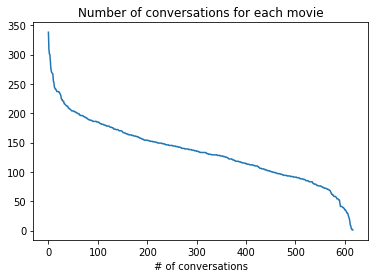

In [9]:
# plot number of conversations for each movie

num_conversations = [len(movie.conversations) for _, movie in movies.items()]
num_conversations = sorted(num_conversations, reverse=True)
num_conversations = np.array(num_conversations)

print(f'Average # of conversations: {num_conversations.mean()}')
print(f'Max # of conversations: {num_conversations.max()}')
print(f'Min # of conversations: {num_conversations.min()}')

plt.plot(num_conversations)
plt.title("Number of conversations for each movie")
plt.xlabel("movie index sorted descendingly by y")
plt.xlabel("# of conversations")

Average # of dialogs: 493.86223662884925
Max # of dialogs: 1530
Min # of dialogs: 6


Text(0.5, 0, '# of dialogs')

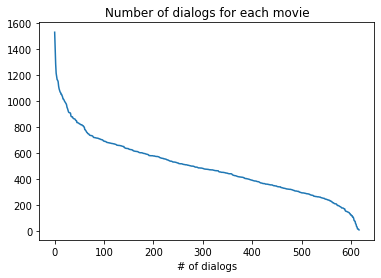

In [10]:
# plot number of dialogs for each movie

num_dialogs = []
for _, movie in movies.items():
    num_dialogs_ = sum([len(convo.dialogs) for convo in movie.conversations])
    num_dialogs.append(num_dialogs_)

num_dialogs = sorted(num_dialogs, reverse=True)
num_dialogs = np.array(num_dialogs)

print(f'Average # of dialogs: {num_dialogs.mean()}')
print(f'Max # of dialogs: {num_dialogs.max()}')
print(f'Min # of dialogs: {num_dialogs.min()}')

plt.plot(num_dialogs)
plt.title("Number of dialogs for each movie")
plt.xlabel("movie index sorted descendingly by y")
plt.xlabel("# of dialogs")

The conversations are like "to-and-fro" style with two characters with
at least 1 dialog for each.
So information from one dialog will flow to the next one within a conversation.


Let's pick a random movie that will stay constant throughout this notebook.

In [11]:
random_movie_id = 17
random_movie = movies[f'm{random_movie_id}']

print(random_movie.title, random_movie.genres)
print('# of conversations', len(random_movie.conversations))

random_conversation_index = np.random.randint(low=0, high=len(random_movie.conversations), size=1)[0]
print(f'Random conversation index: {random_conversation_index}')
random_conversation = random_movie.conversations[random_conversation_index]
print('length of random conversation: ', len(random_conversation.dialogs))
[d.dialog for d in random_conversation.dialogs]

american madness ['drama']
# of conversations 151
Random conversation index: 113
length of random conversation:  3


["The fools! If they only knew it, they're making things worse for themselves. Somebody starts a silly rumor, and they lose their heads.",
 "What'll we do?",
 "I'll talk to them. Listen, go back and tell the boys to stall as much as possible. Tell 'em not to pay any attention to what I said. Tell 'em to verify every signature."]

Average length of conversations: 3.6887417218543046
Max length of conversations: 12
Min length of conversations: 2


Text(0.5, 0, 'length of conversations')

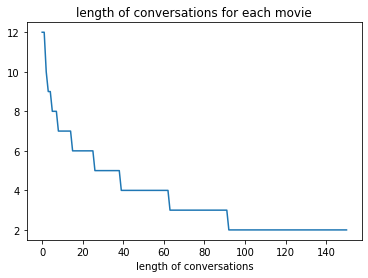

In [12]:
# Plot number of dialogs for each conversation in a random movie.

num_dialogs = [len(convo.dialogs) for convo in random_movie.conversations]
num_dialogs = sorted(num_dialogs, reverse=True)
num_dialogs = np.array(num_dialogs)

print(f'Average length of conversations: {num_dialogs.mean()}')
print(f'Max length of conversations: {num_dialogs.max()}')
print(f'Min length of conversations: {num_dialogs.min()}')

plt.plot(num_dialogs)
plt.title("length of conversations for each movie")
plt.xlabel("movie index sorted descendingly by y")
plt.xlabel("length of conversations")


Breakdown of what we can do with this data:

- within a movie
    - among words
        - tf-idf approach
            - tf-idf where document = conversation
            - Each term should at least be in 2 conversations?
            - Get static embeddings for each high-rank tf-idf terms
            - Do a cartesian product of pairs of these embeddings and find the most similar pairs.
            - Create a network of these pairs based on similar/not. (if similar, there will be a link)
        - embedding appraoch:
            - Do an n-gram and find the segment of a conversation that has the highest
              cosine similarity with the embedding of the entire conversation.
            -
    - among lines
        - a conversation is a continuous stream of dialogs. So get an embedding for it.
        - Do a 2-gram sentences (not 2-gram of words) and feed it to BERT as 2 sequences to get the embedding.
        - Then average all 2-grams to get conversation embedding.
          Or input 2-gram embeddings as word embeddings to get conversation embedding.
        - What's the most "significant" dialog in the conversation that captures the whole conversation?
        - Does the "significant" word from tf-idf correlate with most significant dialogs?
        - Capture similar and dissimilar conversations.
- across movies
    - among words
        - tf-idf where document = movie
        - Show high-rank tf-idf words for each movie
    - among lines
- across corpus
- across genres


## Within a conversation in a movie.

Let's use a pretrained DistilBERT model for word/sentence/sentence-pair embeddings.

I'm using huggingface's `transformers` library. https://huggingface.co/transformers

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased').to(device)
model.eval()
model.device

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


device(type='cpu')

In [14]:
def conversation_to_batch(conversation: Conversation):
    """
    does a 2-gram of dialogs in a conversation.

    examples of sentence_1_batch and sentence_2_batch:
        sentence_1_batch = ['Hello, my dog is cute', 'Hitler was a very bad person']
        sentence_2_batch = ["oh yeah! That's really cute", None]
    """
    dialogs = [d.dialog for d in conversation.dialogs]
    pairs = []
    for i in range(len(dialogs) - 1):
        pairs.append((dialogs[i], dialogs[i+1]))

    sentence_1_batch = [pair[0] for pair in pairs]
    sentence_2_batch = [pair[1] for pair in pairs]

    # This will make sure that all dialogs are seen exactly twice by the model.
    sentence_1_batch = sentence_1_batch + [pairs[0][0], pairs[-1][1]]
    sentence_2_batch = sentence_2_batch + [None, None]

    inputs = tokenizer(sentence_1_batch, sentence_2_batch, padding=True, return_tensors='pt')
    return inputs


def average_pool_without_padding(
    embeddings_batch: torch.Tensor,
    attention_mask_batch: torch.Tensor
) -> torch.Tensor:
    """
    Given an embeddings output of shape (batch, sequence_length, embedding_dim)
    and attention_mask_batch of shape (batch, sequence_length),
    this function will return averaged embeddings without taking padding into account.
    The shape will be (batch, embedding_dim)
    """
    batch_size, sequence_length, embeddings_dim = embeddings_batch.shape
    sequence_lengths_no_padding = torch.count_nonzero(attention_mask_batch, dim=1)
    output_tensor = []
    for i in range(batch_size):
        embeddings_no_padding = embeddings_batch[i][:sequence_lengths_no_padding[i]]
        mean_embedding = torch.mean(embeddings_no_padding, dim=0)
        output_tensor.append(mean_embedding)
    output_tensor = torch.stack(output_tensor)
    return output_tensor


In [15]:
def get_conversation_embedding(conversation: Conversation):
    inputs = conversation_to_batch(conversation)

    # Shows the indices and tokens of first 2 dialogs. Uncomment to debug
    # itos = list(tokenizer.vocab.items())
    # for index in inputs.data['input_ids'][0]:
    #     print(itos[index])

    inputs = {key: value.to(device) for key, value in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    outputs.last_hidden_state = outputs.last_hidden_state.cpu()
    conversation_embeddings = average_pool_without_padding(outputs.last_hidden_state, inputs['attention_mask'])

    # Average all 2-gram sentence embeddings to get conversation embedding.
    conversation_embedding = torch.mean(conversation_embeddings, dim=0)
    return conversation_embedding


def get_dialogs_embeddings(conversation: Conversation):
    dialogs = [d.dialog for d in conversation.dialogs]
    dialogs_inputs = tokenizer(dialogs, padding=True, return_tensors='pt')

    dialogs_inputs = {key: value.to(device) for key, value in dialogs_inputs.items()}
    with torch.no_grad():
        dialogs_embeddings = model(**dialogs_inputs)
    dialogs_embeddings.last_hidden_state = dialogs_embeddings.last_hidden_state.cpu()
    dialogs_embeddings = average_pool_without_padding(
        dialogs_embeddings.last_hidden_state,
        dialogs_inputs['attention_mask']
    )
    return dialogs_embeddings


def get_cos_sim_dialogs_and_conversation(conversation_embedding, dialogs_embeddings):
    cos_sims = []
    for i in range(len(dialogs_embeddings)):
        cos_sim = F.cosine_similarity(dialogs_embeddings[i], conversation_embedding, dim=0)
        # Account for negative cos sim
        cos_sim = int(((float(cos_sim) * 100) + 100) / 2)

        cos_sims.append(cos_sim)
    return cos_sims

In [16]:
conversation_embedding = get_conversation_embedding(random_conversation)
dialogs_embeddings = get_dialogs_embeddings(random_conversation)

conversation_embedding.shape, dialogs_embeddings.shape, dialogs_embeddings.device

(torch.Size([768]), torch.Size([3, 768]), device(type='cpu'))

We got an embedding for the entire conversation. `conversation_embedding`
We also found the embeddings of all dialogs in the conversation.
Of these dialogs, which one represents best the conversation embedding?

Here I'm using cos similarity. One can use eucledian distance as well.
The problem with distance is that it is not bounded b/w 0-1 or something. It is a real number.

In [17]:
cos_sims = get_cos_sim_dialogs_and_conversation(conversation_embedding, dialogs_embeddings)

In [18]:
for i in range(len(cos_sims)):
    print(cos_sims[i], random_conversation.dialogs[i].dialog)

96 The fools! If they only knew it, they're making things worse for themselves. Somebody starts a silly rumor, and they lose their heads.
88 What'll we do?
97 I'll talk to them. Listen, go back and tell the boys to stall as much as possible. Tell 'em not to pay any attention to what I said. Tell 'em to verify every signature.


So we got the most significant dialog in the conversation.
Now what?

We can find the cos-similarity b/w these significant dialogs and see how many are similar.

In [19]:
def get_significant_dialogs(movie: Movie) -> List[Tuple[torch.Tensor, str]]:
    significant_dialogs = []
    for conversation in tqdm(movie.conversations):
        conversation_embedding = get_conversation_embedding(conversation)
        dialogs_embeddings = get_dialogs_embeddings(conversation)
        cos_sims = get_cos_sim_dialogs_and_conversation(conversation_embedding, dialogs_embeddings)
        argmax = np.argmax(cos_sims)
        significant_dialogs.append((
            dialogs_embeddings[argmax],
            conversation.dialogs[argmax].dialog,
        ))
    return significant_dialogs


significant_dialogs = get_significant_dialogs(random_movie)

100%|██████████| 151/151 [01:38<00:00,  1.53it/s]


In [20]:
[d[1] for d in significant_dialogs]

['You here again? What do you want?',
 'What do you suppose anybody wants? Money, money, money!',
 'Tom, I never had trouble getting credit from you before. When I was flat broke you gave me all the money I wanted. Now I come to you with a swell deal, and the greatest\x97',
 "What's the idea of turning her down? It sounds like a perfectly safe investment.",
 'Yeah - sure!',
 "No kidding. When I saw it, you could'a knocked me over with a pin.",
 "Here's twenty-five thousand.",
 'Let me have ten bucks?',
 "I'll pay it back to you Saturday - on the level I will. Give a guy a break, will you? I've got to get it back in my account. If Helen ever finds out that I\x97",
 'Say pal, did you ever hear of a Depression?',
 "Where do you think I've been?  I took the baby for a stroll in the park.",
 'I remember once when your account checked.',
 "And listen, wise guy - I'm setting friend time clock for exactly nine o'clock, so no squawks out of you guys in the morning.",
 'Not yet, Mr. Clark.',
 "P

These dialogs are interesting, but some of them are boring and not "significant".
I want to cluster them into groups.
There's one way to do this.

Find similarity b/w each significant dialog to the others.
Now consider creating a network of these dialogs where similar dialogs have a link.

In [21]:
def get_similar_dialog_pairs(dialogs: List[Tuple[torch.Tensor, str]]) -> List[Tuple[int, int, float]]:
    similar_pairs = []
    for i, (tensor1, dialog1) in enumerate(dialogs):
        for j in range(i + 1, len(dialogs)):
            tensor2, dialog2 = dialogs[j]

            similarity = float(F.cosine_similarity(tensor1, tensor2, dim=0))
            similar_pairs.append((i, j, similarity))

    similar_pairs = sorted(similar_pairs, key=lambda x: -x[2])
    return similar_pairs


all_dialog_pairs = get_similar_dialog_pairs(significant_dialogs)
similar_pairs = all_dialog_pairs[: len(significant_dialogs) // 2]

Average length of conversations: 0.7608779309074873
Max length of conversations: 0.9628100395202637
Min length of conversations: 0.38927698135375977


Text(0.5, 0, 'similarity_scores')

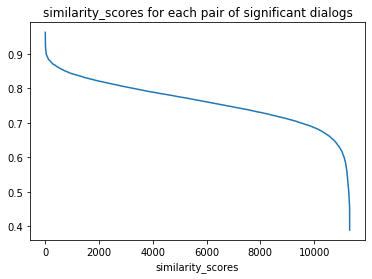

In [22]:
# Plotting similarity scores for the dialogs

similarity_scores = np.array([p[2] for p in all_dialog_pairs])

print(f'Average length of conversations: {similarity_scores.mean()}')
print(f'Max length of conversations: {similarity_scores.max()}')
print(f'Min length of conversations: {similarity_scores.min()}')

plt.plot(similarity_scores)
plt.title("similarity_scores for each pair of significant dialogs")
plt.xlabel("dialog pair index sorted descendingly by y")
plt.xlabel("similarity_scores")

In [23]:
def get_dialogs_network(dialogs, similar_pairs):
    similarity_network = Network(width="1080", notebook=True)

    for i, (_, dialog) in enumerate(dialogs):
        similarity_network.add_node(i, label=dialog, title=dialog, size=10)

    for node1, node2, similarity in similar_pairs:
        width = (similarity) * 10
        similarity_network.add_edge(node1, node2, value=width)

    return similarity_network


dialogs_network = get_dialogs_network(significant_dialogs, similar_pairs)
dialogs_network.show('network.html')
display(HTML('network.html'))

This produces a nice large cluster of dialogs that talk about the same thing.

For movie 17, there are two clusters, linked with one node.
The larger cluster has dialogs that involve some animal killing someone.
The smaller cluster has dialogs that sound "romantic" in a way, like "come closer"-like dialogs.

In theory, the dialogs from this cluster should be enough to infer the genres of the movie.

Now taking an average of the embeddings of these dialogs should give us embedding of the movie.

Doing this for all movies is a long-running task. So I ran it on colab and saved it to disk and loaded it for fast execution.

In [24]:
def get_largest_cluster(similar_pairs):
    similarity_network = nx.Graph()
    similarity_network.add_edges_from([(p[0], p[1]) for p in similar_pairs])

    clusters = list(nx.connected_components(similarity_network))
    largest_cluster = np.argmax([len(s) for s in clusters])
    largest_cluster = list(clusters[largest_cluster])

    return largest_cluster


largest_cluster = get_largest_cluster(similar_pairs)
len(largest_cluster), len(similar_pairs)

(40, 75)

In [25]:
def get_largest_cluster_embeddings(movie: Movie):
    significant_dialogs = get_significant_dialogs(movie)
    similar_pairs = get_similar_dialog_pairs(significant_dialogs)
    largest_cluster = get_largest_cluster(similar_pairs)

    cluster_dialogs = [significant_dialogs[i][1] for i in largest_cluster]
    cluster_embeddings = [significant_dialogs[i][0] for i in largest_cluster]
    cluster_embeddings = torch.stack(cluster_embeddings)

    return {
        'cluster_dialogs': cluster_dialogs,
        'cluster_embeddings': cluster_embeddings
    }

In [26]:
cluster_embeddings_path = f'{BASE_DIR}/data/output/cluster_embeddings'
makedirs(cluster_embeddings_path, exist_ok=True)
files_present = listdir(cluster_embeddings_path)
skip_till = 429

def save_movie_embeddings_to_disk(movies):
    for _, movie in movies.items():
        if movie.id + '.pt' in files_present or int(movie.id[1:]) < skip_till:
            continue
        print(movie.id)

        largest_cluster = get_largest_cluster_embeddings(movie)

        embedding_path = join(cluster_embeddings_path, movie.id + '.pt')
        torch.save(largest_cluster, embedding_path)


# Uncomment this to run embeddings.
# save_movie_embeddings_to_disk(movies)

In [27]:
# Script to download the calculated embeddings from colab to local computer
'''
!ls data/output/cluster_embeddings/
!zip -r cluster_embeddings.zip data/output/cluster_embeddings
!echo "---------"
!ls
from google.colab import files
files.download('cluster_embeddings.zip')
'''

  adding: data/output/cluster_embeddings/ (stored 0%)
---------
__MACOSX                         genre_colab.ipynb
cluster_embeddings.zip           network.html
cornell_movie_dialogs_corpus.zip requirements.txt
data                             something.html
dataset                          temp.py
genre.ipynb


ModuleNotFoundError: No module named 'google.colab'

In [28]:
# Download the movie embeddings from GCP that I ran and saved for faster run.
# Uncomment the lines above to create these from scratch.
# It will take about 15 minutes on Tesla T4

! rm cluster_embeddings*
! wget https://storage.googleapis.com/akhilez/companies/ginger/cluster_embeddings.zip
! rm -rf data/output/cluster_embeddings
! unzip cluster_embeddings.zip -d data/output
! ls data/output/cluster_embeddings

--2021-08-28 18:09:26--  https://storage.googleapis.com/akhilez/companies/ginger/cluster_embeddings.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 2607:f8b0:4009:81c::2010, 2607:f8b0:4009:81a::2010, 2607:f8b0:4009:819::2010, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|2607:f8b0:4009:81c::2010|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 240139990 (229M) [application/zip]
Saving to: ‘cluster_embeddings.zip’

cluster_embeddings. 100%[===================>] 229.01M  34.7MB/s    in 6.5s    

2021-08-28 18:09:33 (35.2 MB/s) - ‘cluster_embeddings.zip’ saved [240139990/240139990]

Archive:  cluster_embeddings.zip
   creating: data/output/cluster_embeddings/
  inflating: data/output/__MACOSX/._cluster_embeddings  
  inflating: data/output/cluster_embeddings/m189.pt  
  inflating: data/output/__MACOSX/cluster_embeddings/._m189.pt  
  inflating: data/output/cluster_embeddings/m218.pt  
  inflating: data/output/__MACOSX/cluster_e

In [29]:
def load_cluster_embeddings(embeddings_path) -> Dict[str, torch.Tensor]:
    embeddings = {}
    files = listdir(embeddings_path)
    for file_name in files:
        movie_id = file_name[:-3]
        embedding = torch.load(join(embeddings_path, file_name))
        embeddings[movie_id] = embedding
    return embeddings


clusters_embeddings = load_cluster_embeddings(cluster_embeddings_path)
clusters_embeddings.keys()

dict_keys(['m189', 'm218', 'm358', 'm249', 'm309', 'm480', 'm591', 'm600', 'm422', 'm562', 'm473', 'm533', 'm507', 'm447', 'm556', 'm416', 'm546', 'm457', 'm517', 'm523', 'm463', 'm572', 'm432', 'm610', 'm581', 'm490', 'm319', 'm259', 'm348', 'm208', 'm199', 'm368', 'm228', 'm339', 'm279', 'm98', 'm552', 'm412', 'm503', 'm443', 'm604', 'm595', 'm484', 'm477', 'm537', 'm426', 'm566', 'm576', 'm436', 'm527', 'm467', 'm494', 'm585', 'm614', 'm453', 'm513', 'm402', 'm542', 'm88', 'm269', 'm329', 'm238', 'm378', 'm369', 'm229', 'm338', 'm278', 'm99', 'm553', 'm413', 'm502', 'm442', 'm594', 'm605', 'm485', 'm476', 'm536', 'm427', 'm567', 'm577', 'm437', 'm526', 'm466', 'm495', 'm615', 'm584', 'm452', 'm512', 'm403', 'm543', 'm89', 'm268', 'm328', 'm239', 'm379', 'm219', 'm188', 'm359', 'm248', 'm308', 'm481', 'm601', 'm590', 'm423', 'm563', 'm472', 'm532', 'm506', 'm446', 'm557', 'm417', 'm407', 'm547', 'm456', 'm516', 'm522', 'm462', 'm573', 'm433', 'm580', 'm611', 'm491', 'm318', 'm258', '

`clusters_embeddings` is a dict of the shape:

```yaml
<movie_1_id>:
    cluster_dialogs:
        - <dialog1:str>
        - <dialog2:str>
        - ...
    cluster_embeddings: <dialogs_embedding:torch.Tensor(n_dialogs,embedding_dim)>
<movie_2_id>:
    ...
```

Now we can average out the cluster embeddings to get embeddings for the movie.

Then we can find similarities b/w all movies and create a network for the movies.



Average cluster_sizes: 135.17320261437908
Max cluster_sizes: 338
Min cluster_sizes: 3


Text(0.5, 0, 'cluster_sizes')

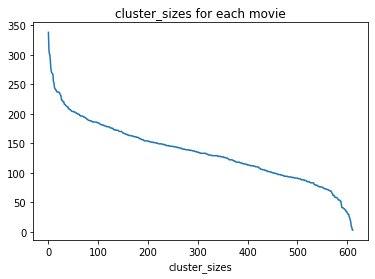

In [30]:
# Plotting similarity scores for the dialogs

cluster_sizes = [len(cluster_dict['cluster_dialogs']) for movie_id, cluster_dict in clusters_embeddings.items()]
cluster_sizes = sorted(cluster_sizes, reverse=True)
cluster_sizes = np.array(cluster_sizes)

print(f'Average cluster_sizes: {cluster_sizes.mean()}')
print(f'Max cluster_sizes: {cluster_sizes.max()}')
print(f'Min cluster_sizes: {cluster_sizes.min()}')

plt.plot(cluster_sizes)
plt.title("cluster_sizes for each movie")
plt.xlabel("movie index sorted descendingly by y")
plt.xlabel("cluster_sizes")

Most cluster sizes (number of significant dialogs that are similar) for the
movies are b/w 75-200.

Average # of dialogs was ~500.

After filtering with similarity cluster technique,
the average # of filtered dialogs is 135. Reduction by 75%.

In [32]:
movies_embeddings = []
for movie_id, cluster_data in clusters_embeddings.items():
    movie_embedding = torch.mean(cluster_data['cluster_embeddings'], dim=0)
    movies_embeddings.append((
        movie_embedding,
        movie_id
    ))

similar_movie_pairs = get_similar_dialog_pairs(movies_embeddings)
similar_movie_pairs = similar_movie_pairs[: len(movie_embedding) // 4]


def get_movies_network(movies_tuples, similar_pairs):
    similarity_network = Network(width="1080", notebook=True)

    connected_nodes = set()
    for node1, node2, _ in similar_pairs:
        connected_nodes.add(node1)
        connected_nodes.add(node2)

    for i, (_, movie_id) in enumerate(movies_tuples):
        if i in connected_nodes:
            genres = str(movies[movie_id].genres)
            title = movies[movie_id].title
            similarity_network.add_node(i, label=title, title=genres, size=10)

    for node1, node2, similarity in similar_pairs:
        width = (similarity) * 10
        similarity_network.add_edge(node1, node2, value=width)

    return similarity_network

movies_network = get_movies_network(movies_embeddings, similar_movie_pairs)
movies_network.show('network.html')
display(HTML('network.html'))

Okay, so we mapped all the movies into this map.
Hovering on the node wil reveal the genre of the movie.

Do we see any pattern?

- small clusters of connected nodes are usually of the same genre.
- connected islands usually contain common genre.
- movie sequels are together

All of this is achieved only with a pretrained model.

# Bag of words approach.

A document is a collection of words in a document.

When a word is repeated often in a document (tf) and does not repeat as often
across documents (idf), then the word is important within that document.
This is loosely how search engines work.

- Here if we consider document as a conversation,
then we will get significant words within a conversation.

- If we consider document as a movie,
then we will get significant words within a movie.

- If we consider document as all the movies in a genre,
then we will get significant words within a genre.

---

In [62]:
spacy_nlp = spacy.load('en_core_web_sm', disable=['tok2vec', 'parser', 'ner'])


def extract_words(text):
    # Without this, there will a ' ' (space) word
    text = re.sub(r'\s+', ' ', text)
    doc = spacy_nlp(text)
    # Words without stopwords
    words = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    return words


extract_words('This is an example of  a sentence. Akhil\'s friends have many cars')

['example', 'sentence', 'akhil', 'friends', 'cars']

In [63]:
bags_of_words_conversation = []
for conversation in random_movie.conversations:
    mini_doc_words = []
    for dialog in conversation.dialogs:
        tokens = extract_words(dialog.dialog)
        mini_doc_words.append(tokens)
    bags_of_words_conversation.append(mini_doc_words)

In [64]:
def _get_word_counts_for_doc_and_mini_doc(bags_of_words) -> List[Dict[str, Dict[str, int]]]:
    """
    refer caller for bags_of_words
    """
    num_documents = len(bags_of_words)
    word_count_documents = [{} for _ in range(num_documents)]

    for d in range(num_documents):
        word_count_mini_doc = word_count_documents[d]

        for mini_doc in bags_of_words[d]:
            word_counts = Counter(mini_doc)

            for word, count in word_counts.items():
                doc_word_count = word_count_mini_doc.get(word, {'mini_doc_count': 0, 'doc_count': 0})
                doc_word_count['mini_doc_count'] += 1
                doc_word_count['doc_count'] += count
                word_count_documents[d][word] = doc_word_count

    return word_count_documents


def _filter_words(word_count_documents, min_tf, min_df, min_mini_df):
    # Remove words that are too infrequent.

    for i, words_count in enumerate(word_count_documents):
        words_to_remove = []
        for word, word_count in words_count.items():
            word_frequency = word_count['doc_count']  # / word_count['mini_doc_count']
            mini_doc_frequency = word_count['mini_doc_count']  # / len(word_count_documents)
            if word_frequency < min_tf or mini_doc_frequency < min_mini_df:
                words_to_remove.append(word)
                # print(f'{word=}, {word_count=}')
        for word in words_to_remove:
            del words_count[word]

    # Remove if word does not appear for min_df documents.
    total_word_counts = [word for doc_counts in word_count_documents for word in doc_counts]
    total_word_counts = Counter(total_word_counts)
    words_to_remove = [word for word in total_word_counts if total_word_counts[word] < min_df]

    for i, words_count in enumerate(word_count_documents):
        for word in words_to_remove:
            del words_count[word]

    return word_count_documents


def get_top_k_indices_from_tfidf(tfidf, all_words, k):
    # Okay, now that we have tf-idf matrix,
    # Let's find the highest ranking top k words for each genre.

    top_k = []

    for i in range(len(tfidf)):
        tfidf_ranks = tfidf[i]
        indices = list(range(len(tfidf_ranks)))

        zipped = zip(tfidf_ranks, indices)
        pairs = heapq.nlargest(k, zipped)
        keywords = [all_words[pair[1]] for pair in pairs]

        top_k.append(keywords)

    return top_k


def custom_tf_idf(bags_of_words: List[List[List[str]]], min_tf=1, min_df=1, min_mini_df=1, top_k=10):
    """
    bags_of_words is a list of documents.
    a document is a list of mini_documents.
    a mini_document is a list of word tokens.

    min_tf is the minimum term frequency in a document.

    min_df is the minimum # of documents a word should repeat.

    min_mini_df is the minimum # of mini-documents a word should repeat.
    """

    word_count_documents = _get_word_counts_for_doc_and_mini_doc(bags_of_words)
    word_count_documents = _filter_words(word_count_documents, min_tf, min_df, min_mini_df)

    all_words = list(set([word for doc_counts in word_count_documents for word in doc_counts]))

    frequency_matrix = np.zeros((len(bags_of_words), len(all_words)), dtype=int)

    for i in range(len(bags_of_words)):
        for j, word in enumerate(all_words):
            if word in word_count_documents[i]:
                frequency = word_count_documents[i][word]
                frequency = frequency['doc_count']  # / frequency['mini_doc_count']
                frequency_matrix[i][j] = frequency

    inter_doc_word_counts = frequency_matrix.sum(0)
    tfidf = frequency_matrix / inter_doc_word_counts

    top_k = get_top_k_indices_from_tfidf(tfidf, all_words, k=top_k)

    return top_k

In [65]:
topk = custom_tf_idf(bags_of_words_conversation, top_k=5)
topk

[['hello', 'tom', 'want', 'nightmare', 'later'],
 ['wants', 'anybody', 'suppose', 'money', 'told'],
 ['broke', 'credit', 'crowd', 'greatest\x97', 'flat'],
 ['mortgages', 'turning', 'perfectly', 'investment', 'widows'],
 ['foreclose', 'sure\x97', 'pay', 'sure', 'wo'],
 ['detectives', 'knocked', 'stairs', 'tough', 'kidding'],
 ['manville', 'payrolls', 'thousand', 'week', 'yeah'],
 ['favor', 'bucks', 'quit', 'charlie', 'yeah'],
 ['break', 'level', 'saturday', 'finds', 'baby'],
 ['nerts', 'depression', 'pal', 'kick', 'hear'],
 ['stroll', 'park', 'baby', 'took', 'think'],
 ['mistake', 'checked', 'date', 'fourteen', 'remember'],
 ['squawks', 'setting', 'troubles', 'annoy', 'wise'],
 ['delay', 'clark', 'waiting', 'comes', 'room'],
 ['paper', 'tolerate', 'institution', 'unsecured', 'fools'],
 ['schultz', 'doubtful', 'trust\x97', 'agree', 'loans'],
 ['idiotic', 'loans', 'clark', 'depositors', 'easy'],
 ['hearing', 'gives', 'wants', 'control', 'shut'],
 ['ball', 'ahead', 'valuable', 'anything\x9

In [ ]:

# Find word counts for each genre.
genre_words_count = {genre: {} for genre in all_genres}

for _, movie in tqdm(movies.items()):
    dialogs = '. '.join([d.dialog for conversation in movie.conversations for d in conversation.dialogs])
    words = extract_words(dialogs)
    word_frequencies = Counter(words)

    for genre in movie.genres:
        for word, count in word_frequencies.items():
            genre_word_count = genre_words_count[genre].get(word, {'movie_count': 0, 'count': 0})
            genre_word_count['movie_count'] += 1
            genre_word_count['count'] += count
            genre_words_count[genre][word] = genre_word_count

In [ ]:
# Remove words that are too infrequent.

# Anything count < infrequent_threshold is removed.
infrequent_threshold = 3

# At least this % of movies should contain the genre-defining words
infrequent_movie_threshold = 0.25

for genre, words_count in genre_words_count.items():
    words_to_remove = []
    for word, word_count in words_count.items():
        word_frequency = word_count['count']  # / word_count['movie_count']
        movie_frequency = word_count['movie_count'] / genre_movies_count[genre]
        if word_frequency < infrequent_threshold or movie_frequency < infrequent_movie_threshold:
            words_to_remove.append(word)
            # print(f'{word=}, {word_count=}')
    for word in words_to_remove:
        del words_count[word]



frequency_matrix = np.zeros((len(all_genres), len(all_words)), dtype=int)

for i, genre in enumerate(all_genres):
    for j, word in enumerate(all_words):
        if word in genre_words_count[genre]:
            frequency = genre_words_count[genre][word]
            frequency = frequency['count']  # / frequency['movie_count']
            frequency_matrix[i][j] = frequency

frequency_matrix

In [ ]:
inter_genre_word_counts = frequency_matrix.sum(0)
inter_genre_word_counts

In [ ]:
tfidf = frequency_matrix / inter_genre_word_counts
tfidf

In [ ]:
# Okay, now that we have tf-idf matrix,
# Let's find the highest ranking top k words for each genre.

for i in range(len(all_genres)):
    tfidf_ranks = tfidf[i]
    counts = frequency_matrix[i]

    zipped = zip(tfidf_ranks, all_words, counts, inter_genre_word_counts)
    pairs = heapq.nlargest(10, zipped)
    keywords = [pair[1] for pair in pairs]
    print(f'{all_genres[i]}: {pairs}')


## 1. Conversation as document
i.e. best words for each conversation.

----------------------------------------------------------------------------------

# Classification

There's no "description" or "plot summary" of movies.
So one must look at all the dialogs and decipher the movie genre.

How can we do this?
Let's do this in a naive way first, then let's try to get creative.

## Naive way:

- Average all word embeddings in a dialog to get dialog embeddings.
- Average all dialog embeddings to get movie plot embedding.

Thought process:
  - We get a sentence embedding by averaging the word embeddings
  - In the same way, can we get "scene" embedding by averaging all the sentence embeddings in a scene?
  - Then averaging all scene embeddings should give us movie embedding.
  - We don't have scenes, do we? If not, we can skip scenes, will averaging all dialog embeddings give us movie embedding?

Problems:

- The conversations might mostly include "everyday lines" that do not relate to the plot.
- For example, "You must learn how to lie", "they have to!" do not say anything about the plot.

## Another method:

- Find all genre-defining keywords.
- Then get the dialogs with these keywords.
- Assumption: dialogs with keywords will contain plot-related information.
-

---

## Rule-based method for baseline.

For each genre, what are the most used words? (after removing the stopwords)
How many of these words occur for multiple movies?

Intuitive rationale:

- [Within one genre] a genre-defining word will likely have high frequency in a movie and among all movies of the same genre.
- [Among genres] a genre-defining word will likely have high frequency in movies within the genre and low frequency among movies of other genres.

This can be obtained by finding the tf-idf value for each word in the corpus.

If frequency of a word is low among movies of the same genre, then it is likely not genre-defining.

Assuming that we obtained these "genre-defining" words for each genre,
the next task would be to somehow learn that these words (or similar words) will help predict the movie's genre.

### Implementation:

1. Parse all the data.
2. store all the genres.
3. Split 95:5 of the movies randomly (less data problem!)
4. Find tf-idf of each word in the training set. document = genre.
5. Can these be custom named entities?

Part 1:

Well, we need lines for each genre. We don't care about the "sequential" nature of dialogs. Just need all of them.

Specifically, we need a structure like this:

- genres
    - movies
        - words

Here words are obtained by:

- spaCy tokenize each dialog.
- spaCy lemmatize
- spaCy remove stopwords

Note that a movie can have multiple genres. So the dialogs for two genres might repeat.

Part 2:


---

## Generating training data

Can we use these "significant-dialogs" to predict genre?
That might be possible.

A training pipeline could look like following:

- A random sample of dialogs from this cluster could contain enough information
about the genre.
- So during training, every sample in a training batch could be a
"average embeddings of randomly sampled subset of significant dialogs of a movie with replacement".
- The reason for random subset's embedding as input as opposed to all the
dialogs is to increase the variation in the training data.



In [ ]:
class DialogClusterDataset(Dataset):
    def __init__(
        self,
        movies: Dict[str, Movie],
        clusters_embeddings: Dict[str, Dict[str, Union[torch.Tensor, List[str]]]],
        all_genres: List[str],
        dialog_sample_size: int,
    ):
        """
        This dataset yields a movie embedding by randomly selecting some dialogs
        from clusters_embeddings.


        dialog_sample_size is the number of dialog embeddings to sample randomly
        from the dialog embeddings.

        `clusters_embeddings` is a dict of the shape:

        ```yaml
        <movie_1_id>:
            cluster_dialogs:
                - <dialog1:str>
                - <dialog2:str>
                - ...
            cluster_embeddings: <dialogs_embedding:torch.Tensor(n_dialogs,embedding_dim)>
        <movie_2_id>:
            ...
        ```
        """
        self.movies = movies
        self.clusters_embeddings = clusters_embeddings
        self.all_genres = sorted(all_genres)
        self.dialog_sample_size = dialog_sample_size

        self.movie_ids = list(self.clusters_embeddings.keys())


    def __len__(self):
        return len(self.movie_ids)

    def __getitem__(self, index: int):
        movie_id = self.movie_ids[index]

        movie_embedding = self._get_movie_embedding(movie_id)
        genre_vector = self._get_genre_vector(self.movies[movie_id].genres)

        return movie_embedding, genre_vector

    def _get_genre_vector(self, genres: List[str]):
        genres = [genre in genres for genre in self.all_genres]
        genres = torch.tensor(genres) * 1
        return genres

    def _get_movie_embedding(self, movie_id: str):
        embeddings = self.clusters_embeddings[movie_id]['cluster_embeddings']

        num_dialogs = len(embeddings)
        sample_size = min(num_dialogs, self.dialog_sample_size)

        random_indices = torch.randint(low=0, high=num_dialogs, size=sample_size)

        subsampled_embeddings = embeddings[random_indices]

        final_embedding = torch.mean(subsampled_embeddings, dim=0)
        return final_embedding


dataset = DialogClusterDataset(
    movies=movies,
    clusters_embeddings=clusters_embeddings,
    all_genres=all_genres,
    dialog_sample_size=15,
)

In [ ]:
list(movies.keys())[:5]

In [ ]:
m0 = movies['m0']

In [ ]:
list(m0.characters.keys())[:5]

In [ ]:
conversations = m0.conversations[:5]
conversations[0].dialogs[0].dialog

In [ ]:
all_genres = [genre for _, movie in movies.items() for genre in movie.genres]
genre_movies_count = Counter(all_genres)
all_genres = list(set(all_genres))

# Sorting by value to see which genres have the most movies.
sorted(genre_movies_count.items(), key=lambda item: item[1], reverse=True)

In [ ]:
# Well, there's one movie without any genre. So let's put that as 'other'
all_genres.append('other')
all_genres.remove('')

genre_movies_count['other'] = genre_movies_count['']
del genre_movies_count['']

# Let's also replace '' with 'other' in all movies
for _, movie in movies.items():
    if '' in movie.genres:
        movie.genres.append('other')
        movie.genres.remove('')

In [ ]:
# Some of the genres have very low movie count.
# This will make the frequency based method very difficult.
# We might employ other techniques for these low-frequent genres.
# For now, to make the problem easier, let's only use the high frequent genres only.

# Eliminating all genres with frequency < 75 (75 is just based on intuition.)
low_frequency_genres = [genre for genre in all_genres if genre_movies_count[genre] <= 75]

for genre in low_frequency_genres:
    # Remove from all_genres
    all_genres.remove(genre)

    # Remove from movie.genres
    for _, movie in movies.items():
        if genre in movie.genres:
            movie.genres.remove(genre)

# Remove movies with empty genres
movies_to_remove = []
for movie_id, movie in movies.items():
    if len(movie.genres) == 0:
        movies_to_remove.append(movie_id)
for movie_id in movies_to_remove:
    del movies[movie_id]

In [ ]:
# [NOT USED] Creates text files with all dialogs of each genre. NOT USED, but works.

@contextmanager
def get_genre_dialogs_files(output_path: str, genres: List[str], mode: str):
    """
    A wrapper that encapsulates handling multiple genre-dialogs files.
    """
    makedirs(output_path, exist_ok=True)
    files: Dict[str, TextIO] = {genre: open(join(output_path, f'{genre}.txt'), mode) for genre in genres}

    try:
        yield files
    finally:
        for genre in genres:
            files[genre].close()


def create_genre_dialogs_files():
    # Creating dialogs text files for each genre.
    genre_dialogs_path = '/Users/akhil/code/lexical_lab/companies/ginger/data/output/genre_dialogs'
    with get_genre_dialogs_files(genre_dialogs_path, all_genres, 'w') as genre_dialogs_files:
        for _, movie in movies.items():
            for conversation in movie.conversations:
                for dialog in conversation.dialogs:
                    for genre in movie.genres:
                        genre_dialogs_files[genre].write(dialog.dialog + '\n')


In [33]:
"""
Creating a structure like this:
- genres
    - movies
        - words
"""

['example', 'sentence', 'akhil', 'friends', 'cars']

In [ ]:
# Building word frequency table.

# all words in this frequency table
all_words = list(set([word for word_counts in genre_words_count.values() for word in word_counts]))
len(all_words)

In [ ]:
# TODO: Word cloud for these words.
# TODO: Movie 2d map based on semantic genre.
# TODO: graph for # of movies and # of dialogs for each genre.
